# MSAS SOH@EFC600 Training Trial

This notebook runs a quick training+evaluation pass using the MSAS EFC-aligned
feature/label configuration. It is intended as a smoke test.

Prereqs:
- `data/processed/MSAS` exists (run MSAS preprocessing first).
- `batteryml` is importable in this environment.

Notes:
- If you changed feature/label logic, clear cached datasets in `cache/`.
- This config uses CC-only Q with tail CV trimming.


In [1]:
from batteryml.pipeline import Pipeline

In [2]:
from pathlib import Path
import os
import batteryml

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "batteryml").exists() and (p / "configs").exists():
            return p
    return start

env_root = os.environ.get("BATTERYML_REPO_ROOT")
if env_root:
    repo_root = Path(env_root)
else:
    repo_root = find_repo_root(Path.cwd())
    if not (repo_root / "configs").exists():
        pkg_root = Path(batteryml.__file__).resolve().parents[1]
        repo_root = find_repo_root(pkg_root)

os.chdir(repo_root)
config_path = repo_root / "configs/soh/transfer/msas_soh_efc600_efcnorm_ridge.yaml"
workspace = repo_root / "workspaces/msas/soh_efc600_ridge_trial"
data_root = repo_root / "data/processed/MSAS"

print("repo_root:", repo_root)
print("config_path:", config_path)
print("data_root:", data_root)

if not config_path.exists():
    raise FileNotFoundError(
        f"Config not found: {config_path}. Set BATTERYML_REPO_ROOT if needed."
    )
if not data_root.exists():
    raise FileNotFoundError(
        f"MSAS processed data not found: {data_root}. Run preprocessing first."
    )

pipe = Pipeline(config_path=str(config_path), workspace=str(workspace))
model, dataset = pipe.train(skip_if_executed=False)
prediction = model.predict(dataset)
scores = {m: dataset.evaluate(prediction, m) for m in ["RMSE", "MAE"]}
print(scores)

repo_root: c:\Users\FanWang\Documents\GitHub\BatteryML
config_path: c:\Users\FanWang\Documents\GitHub\BatteryML\configs\soh\transfer\msas_soh_efc600_efcnorm_ridge.yaml
data_root: c:\Users\FanWang\Documents\GitHub\BatteryML\data\processed\MSAS
c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\soh_efc600_ridge_trial
Seed is set to 0.


Extracting features: 100%|██████████| 31/31 [00:00<00:00, 964.14it/s]


{'RMSE': 0.007855798881921469, 'MAE': 0.005850401677455029}


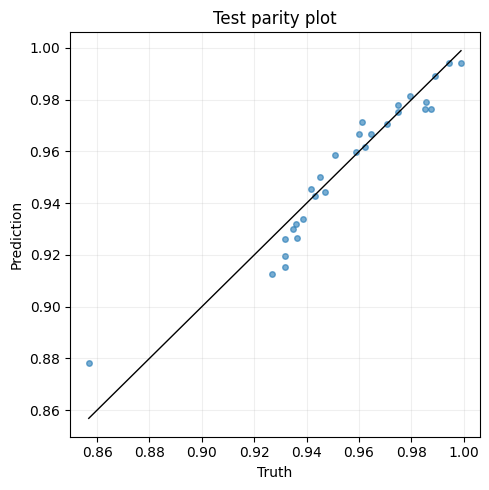

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Parity plot for test set
y_true = dataset.test_data.label
y_pred = prediction

if dataset.label_transformation is not None:
    y_true = dataset.label_transformation.inverse_transform(y_true)
    y_pred = dataset.label_transformation.inverse_transform(y_pred)

y_true = y_true.detach().cpu().numpy().reshape(-1)
y_pred = y_pred.detach().cpu().numpy().reshape(-1)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_true, y_pred, alpha=0.6, s=16)
min_v = float(np.min([y_true.min(), y_pred.min()]))
max_v = float(np.max([y_true.max(), y_pred.max()]))
ax.plot([min_v, max_v], [min_v, max_v], color="black", linewidth=1)
ax.set_xlabel("Truth")
ax.set_ylabel("Prediction")
ax.set_title("Test parity plot")
ax.grid(True, alpha=0.2)
plt.tight_layout()